In [17]:
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

# <p style="text-align: center;"> MALAP TP4 - Perceptron, SVMs </p>
#### <p style="text-align: center;"> Clément RIU et Anne SPITZ </p>
#### <p style="text-align: center;"> 13/04/2017 </p>

Fichier tools.py :

In [2]:
def plot_data(data, labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols, marks = ["red", "blue", "green", "orange", "black", "cyan"], [".", "+", "*", "o", "x", "^"]
    if labels is None:
        plt.scatter(data[:, 0], data[:, 1], marker="x")
        return
    for i, l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels == l, 0], data[labels == l, 1], c=cols[i], marker=marks[i])

        
def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),256)


def make_grid(data=None, xmin=-5, xmax=5, ymin=-5, ymax=5, step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:, 0]), np.min(data[:, 0]), np.max(data[:, 1]), np.min(data[:, 1])
    x, y = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step), np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    grid = np.c_[x.ravel(), y.ravel()]
    return grid, x, y


def gen_arti(centerx=1, centery=1, sigma=0.1, nbex=1000, data_type=0, epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type == 0:
        # melange de 2 gaussiennes
        xpos = np.random.multivariate_normal([centerx, centerx], np.diag([sigma, sigma]), int(nbex // 2))
        xneg = np.random.multivariate_normal([-centerx, -centerx], np.diag([sigma, sigma]), int(nbex // 2))
        data = np.vstack((xpos, xneg))
        y = np.hstack((np.ones(nbex // 2), -np.ones(nbex // 2)))
    if data_type == 1:
        # melange de 4 gaussiennes
        xpos = np.vstack((np.random.multivariate_normal([centerx, centerx], np.diag([sigma, sigma]), int(nbex // 4)),
                          np.random.multivariate_normal([-centerx, -centerx], np.diag([sigma, sigma]), int(nbex / 4))))
        xneg = np.vstack((np.random.multivariate_normal([-centerx, centerx], np.diag([sigma, sigma]), int(nbex // 4)),
                          np.random.multivariate_normal([centerx, -centerx], np.diag([sigma, sigma]), int(nbex / 4))))
        data = np.vstack((xpos, xneg))
        y = np.hstack((np.ones(nbex // 2), -np.ones(int(nbex // 2))))

    if data_type == 2:
        # echiquier
        data = np.reshape(np.random.uniform(-4, 4, 2 * nbex), (nbex, 2))
        y = np.ceil(data[:, 0]) + np.ceil(data[:, 1])
        y = 2 * (y % 2) - 1
    # un peu de bruit
    data[:, 0] += np.random.normal(0, epsilon, nbex)
    data[:, 1] += np.random.normal(0, epsilon, nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data = data[idx, :]
    y = y[idx]
    return data, y


Fichier tp4-etu.py :

In [3]:
class Perceptron:
    def __init__(self, max_iter=100, eps=1e-3, projection=None):
        self.max_iter = max_iter
        self.eps = eps
        self.projection = projection or (lambda x: x)  # projection fonction identite par default

    def fit(self, data, y):
        data = self.projection(data)
        self.w = np.random.random((1, data.shape[1]))
        self.histo_w = np.zeros((self.max_iter, data.shape[1]))
        self.histo_f = np.zeros((self.max_iter, 1))
        ylab = set(y.flat)
        if len(ylab) != 2:
            print("pas bon nombres de labels (%d)" % (ylab,))
            return
        self.labels = {-1: min(ylab), 1: max(ylab)}
        y = 2 * (y != self.labels[-1]) - 1
        i = 0
        while i < self.max_iter:
            idx = range(len(data))
            for j in idx:
                self.w = self.w - self.get_eps() * self.loss_g(data[j], y[j:(j + 1)])
            self.histo_w[i] = self.w
            self.histo_f[i] = self.loss(data, y)
            if i % 20 == 0: print(i, self.histo_f[i])
            i += 1

    def predict(self, data):
        data = self.projection(data)
        return np.array([self.labels[x] for x in np.sign(data.dot(self.w.T)).flat]).reshape((len(data),))

    def score(self, data, y):
        return np.mean(self.predict(data) == y)

    def get_eps(self):
        return self.eps

    def loss(self, data, y):
        return hinge(self.w, data, y)

    def loss_g(self, data, y):
        return grad_hinge(self.w, data, y)

Fichier tp3-etu.py :

In [4]:
def load_usps(filename):
    with open(filename, "r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split()) > 2]
    tmp = np.array(data)
    return tmp[:, 1:], tmp[:, 0].astype(int)


def get_usps(l, datax, datay):
    """ l : liste des chiffres a extraire"""
    if type(l) != list:
        resx = datax[datay == l, :]
        resy = datay[datay == l]
        return resx, resy
    tmp = list(zip(*[get_usps(i, datax, datay) for i in l]))
    tmpx, tmpy = np.vstack(tmp[0]), np.hstack(tmp[1])
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx, :], tmpy[idx]


def show_usps(data):
    plt.imshow(data.reshape((16, 16)), interpolation="nearest", cmap="gray")


## <p style="text-align: center;"> 1 Implémentation du perceptron </p>

### Question 1.1 :

In [5]:
def hinge(w, data, y):
    """"""
    data, y, w = data.reshape(len(y), -1), y.reshape(-1, 1), w.reshape(1, -1)
    return np.mean(np.maximum(0, -np.multiply(y, np.dot(data, w.T))))
    
def grad_hinge(w, data, y):
    """"""
    data, y, w = data.reshape(len(y), -1), y.reshape(-1, 1), w.reshape(1, -1)
    
    value = - np.multiply(y, data)    
    sign = np.multiply(y, np.dot(data, w.T)) < 0
    
    return np.mean(np.multiply(sign, value), axis = 0)


In [6]:
### Test des fonctions hinge et grad_hinge
w = np.random.random((3,))
data = np.random.random((100, 3))
y = np.random.randint(0, 2, size=(100, 1)) * 2 - 1

print(hinge(w, data, y), hinge(w, data[0], y[0]), hinge(w, data[0, :], y[0]))
print(grad_hinge(w, data, y), grad_hinge(w, data[0], y[0]).shape, grad_hinge(w, data[0, :], y[0]).shape)

0.186873455552 0.466139049499 0.466139049499
[ 0.24953988  0.25559237  0.23684628] (3,) (3,)


### Question 1.2 :

0 [ 0.00072768]
20 [ 0.00048206]
40 [ 0.00029825]
60 [ 0.00011761]
80 [  3.62674717e-05]
score en train :  0.991
score en test :  0.99


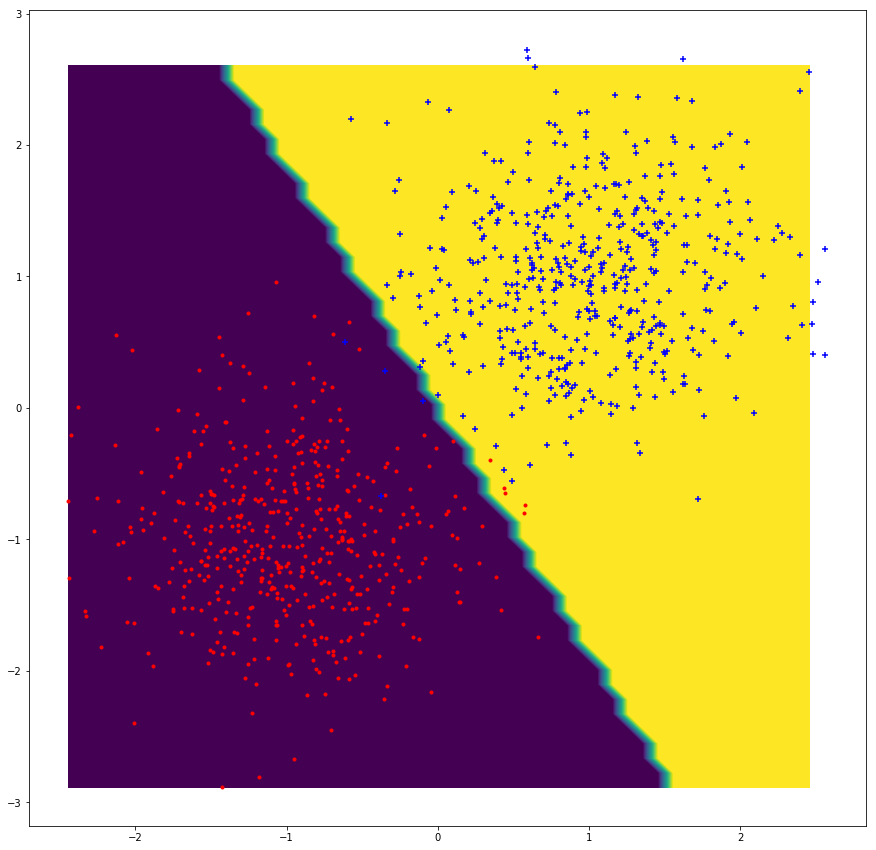

In [7]:
### Generation de donnees

xtrain, ytrain = gen_arti(data_type=0, epsilon=0.5)
xtest, ytest = gen_arti(data_type=0, epsilon=0.5)

### Apprentissage
model = Perceptron(max_iter=100, eps=1e-2)
model.fit(xtrain, ytrain)
print("score en train : ", model.score(xtrain, ytrain))
print("score en test : ", model.score(xtest, ytest))

#### Tracer de frontiere
plt.figure(num=None, figsize=(15, 15))
plot_frontiere(xtrain, model.predict, 50)
plot_data(xtrain, ytrain)
plt.show()

#### Visualisation de la fonction de cout
# plt.figure()
# plot_frontiere(data=None, f=lambda w: hinge(w, xtrain, ytrain))

## <p style="text-align: center;"> 2 Données USPS </p>

### Question 2.1 :

0 [ 2.11259115]
20 [ 0.0499817]
40 [ 0.0402162]
60 [ 0.03151904]
80 [ 0.0369923]
score en train :  0.971447994562
score en test :  0.922305764411


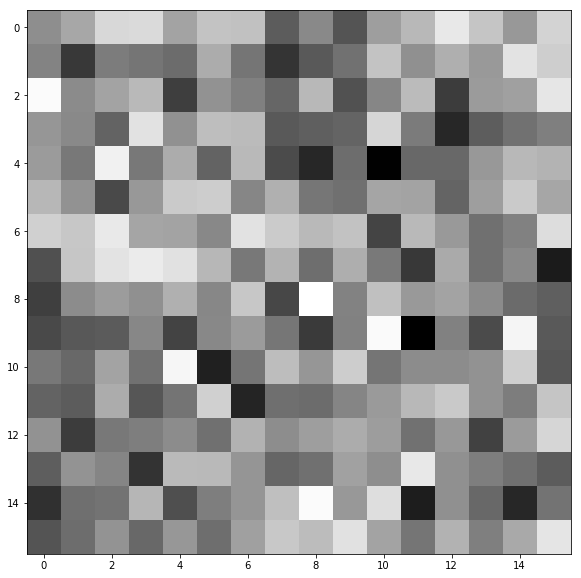

bonjour


In [8]:
# Observation de données réelles :
xuspstrain, yuspstrain = load_usps("USPS_train.txt")
xuspstest, yuspstest = load_usps("USPS_test.txt")
x16train, y16train = get_usps([1, 6], xuspstrain, yuspstrain)
x28train, y28train = get_usps([2, 8], xuspstrain, yuspstrain)
x16test, y16test = get_usps([1, 6], xuspstest, yuspstest)
x28test, y28test = get_usps([2, 8], xuspstest, yuspstest)
x1268train = np.concatenate((x16train, x28train))
x1268test = np.concatenate((x16test, x28test))
y1268train = np.concatenate((y16train, y28train))
y1268test = np.concatenate((y16test, y28test))
y1268train[y1268train == 2] = 1
y1268train[y1268train == 8] = 6
y1268test[y1268test == 2] = 1
y1268test[y1268test == 8] = 6

x_chiffre_train = x1268train
x_chiffre_test = x1268test
y_chiffre_train = y1268train
y_chiffre_test = y1268test

### Apprentissage
model = Perceptron(eps=1e-2)
model.fit(x_chiffre_train, y_chiffre_train)
print("score en train : ", model.score(x_chiffre_train, y_chiffre_train))
print("score en test : ", model.score(x_chiffre_test, y_chiffre_test))

plt.figure(num=None, figsize=(20, 10))
show_usps(np.reshape(model.w, (16, 16)))
plt.show()

print("bonjour")

### Question 2.2 :

In [14]:
err_train = []
err_test = []
    
for max_iter in range(1,200,20):
    ### Apprentissage
    model = Perceptron(max_iter=max_iter, eps=1e-2)
    model.fit(x_chiffre_train, y_chiffre_train)
    err_train.append(model.score(x_chiffre_train, y_chiffre_train))
    err_test.append(model.score(x_chiffre_test, y_chiffre_test))


line = []
plt.figure(num=None, figsize=(15, 15))
line.append(plt.plot(err_train, label="train"))
line.append(plt.plot(err_test, label="test"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handler_map={line[0][0]: HandlerLine2D(numpoints=4)})
plt.show()

print("bonjour")

0 [ 1.3561158]
0 [ 2.03450361]
20 [ 0.14710107]
0 [ 1.73053497]
20 [ 0.06701195]
40 [ 0.04471654]
0 [ 1.95571483]
20 [ 0.09669205]
40 [ 0.07060424]
60 [ 0.03676656]
0 [ 1.70624674]
20 [ 0.10009081]
40 [ 0.0653392]
60 [ 0.03336725]
80 [ 0.06169456]
0 [ 1.4420819]
20 [ 0.07946009]
40 [ 0.04686748]
60 [ 0.03924387]
80 [ 0.0479854]
100 [ 0.02557453]
0 [ 1.98226034]
20 [ 0.08714909]
40 [ 0.06191324]
60 [ 0.02283309]
80 [ 0.03517649]
100 [ 0.01756578]
120 [ 0.03379344]
0 [ 1.81796376]
20 [ 0.09138363]
40 [ 0.03088911]
60 [ 0.03689071]
80 [ 0.03325559]
100 [ 0.0250312]
120 [ 0.02277944]
140 [ 0.0417899]
0 [ 1.70471892]
20 [ 0.18971951]
40 [ 0.06078353]
60 [ 0.04517439]
80 [ 0.03409583]
100 [ 0.02474451]
120 [ 0.02647582]
140 [ 0.02928816]
160 [ 0.0239595]
0 [ 1.93291973]
20 [ 0.12030811]
40 [ 0.03723553]
60 [ 0.03388709]
80 [ 0.03804078]
100 [ 0.04119275]
120 [ 0.02952609]
140 [ 0.01789545]
160 [ 0.04156525]
180 [ 0.02653613]


NameError: name 'HandlerLine2D' is not defined

## <p style="text-align: center;"> 3 Expréssivité et feature map </p>

### Question 3.1 :

0 [ 0.00691057]
20 [ 0.00461036]
40 [ 0.00737424]
60 [ 0.00773897]
80 [ 0.00565902]
score en train :  0.504
score en test :  0.496


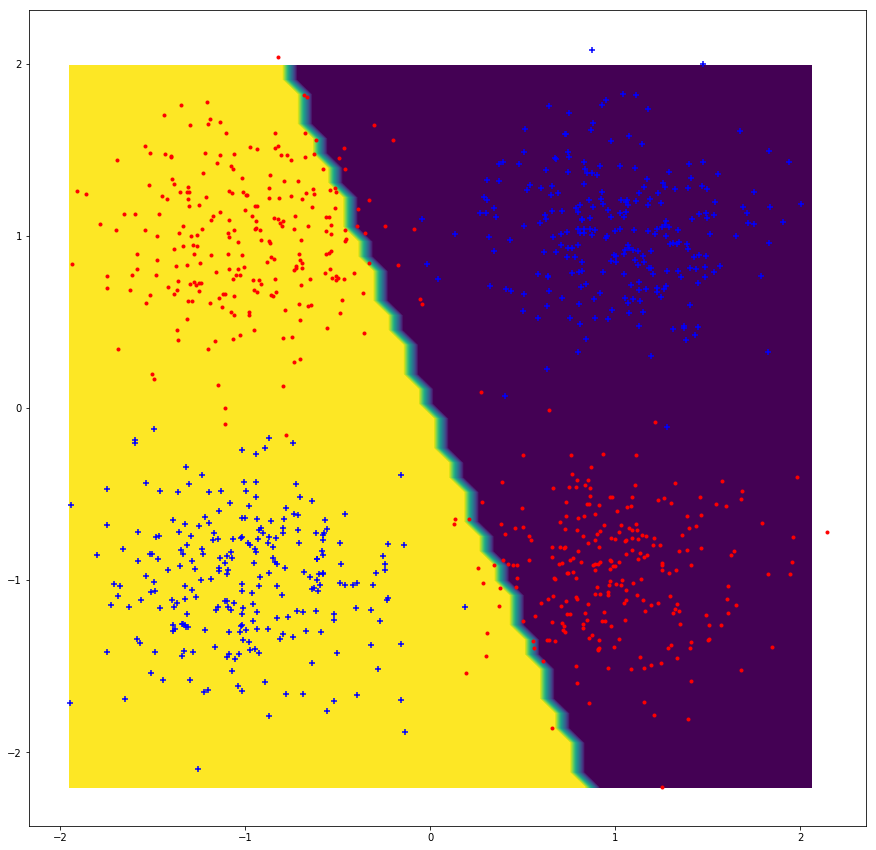

In [19]:
### Generation de donnees

xtrain, ytrain = gen_arti(data_type=1, epsilon=0.2)
xtest, ytest = gen_arti(data_type=1, epsilon=0.2)

### Apprentissage
model = Perceptron(eps=1e-2)
model.fit(xtrain, ytrain)
print("score en train : ", model.score(xtrain, ytrain))
print("score en test : ", model.score(xtest, ytest))

#### Tracer de frontiere
plt.figure(num=None, figsize=(15, 15))
plot_frontiere(xtrain, model.predict, 50)
plot_data(xtrain, ytrain)
plt.show()

### Question 3.2 :

In [20]:
def poly(x):
    """"""
    return np.array([np.ones(x.shape[0]), x[:, 0], x[:, 1], x[:, 0] * x[:, 1], x[:, 0] ** 2, x[:, 1] ** 2]).T

0 [ 0.00242991]
20 [ 0.00012418]
40 [ 0.00013497]
60 [ 0.00013387]
80 [ 0.00013471]
score en train :  0.994
score en test :  0.985


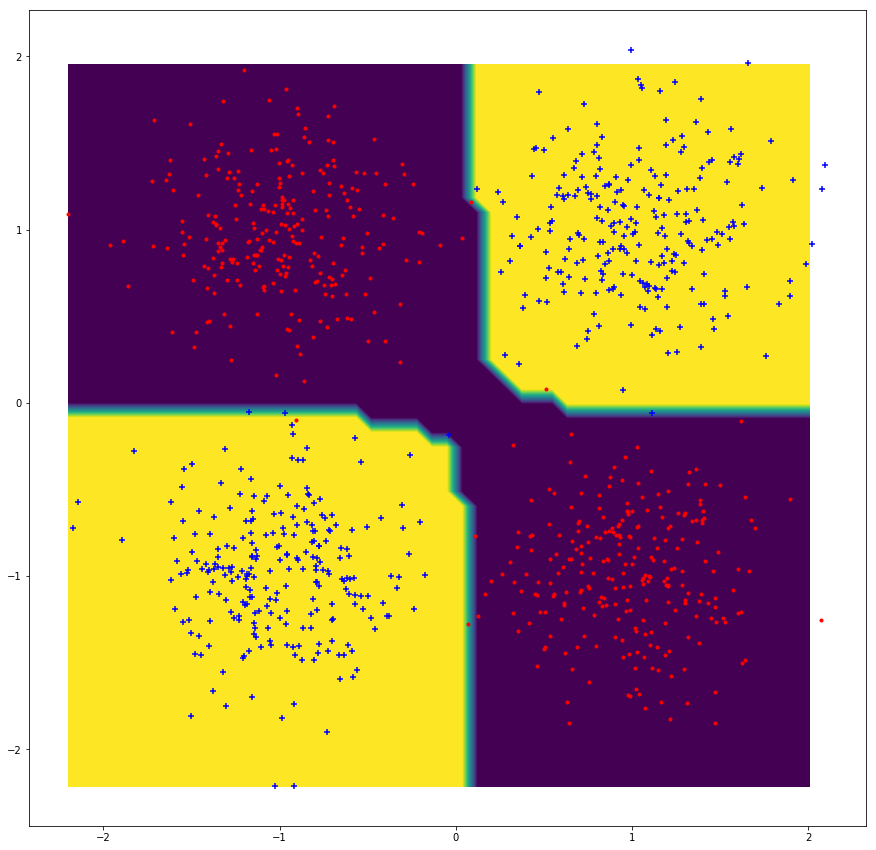

In [21]:
### Generation de donnees

xtrain, ytrain = gen_arti(data_type=1, epsilon=0.2)
xtest, ytest = gen_arti(data_type=1, epsilon=0.2)

### Apprentissage
model = Perceptron(eps=1e-2, projection=poly)
model.fit(xtrain, ytrain)
print("score en train : ", model.score(xtrain, ytrain))
print("score en test : ", model.score(xtest, ytest))

#### Tracer de frontiere
plt.figure(num=None, figsize=(15, 15))
plot_frontiere(xtrain, model.predict, 50)
plot_data(xtrain, ytrain)
plt.show()

### Question 3.3 :

In [22]:
def k(x, x_p, sigma):
    """"""
    
    return np.exp(- np.linalg.norm(x - x_p, axis=0) / 2 / sigma**2)

def kernel(x, o, n_dim=6, sigma=0.5):
    """"""
    n_ex, n_dim_in  = x.shape
    
    x_proj = np.zeros((n_ex, n_dim))

    for dim in range(n_dim):
        for example in range(n_ex):
            x_proj[example, dim] = k(x[example, :], o[dim, :], sigma)
    
    return x_proj


0 [ 0.07879202]
20 [  7.58462460e-05]
40 [  6.29459952e-05]
60 [  6.79940396e-05]
80 [  7.39507442e-05]
score en train :  0.988
score en test :  0.981


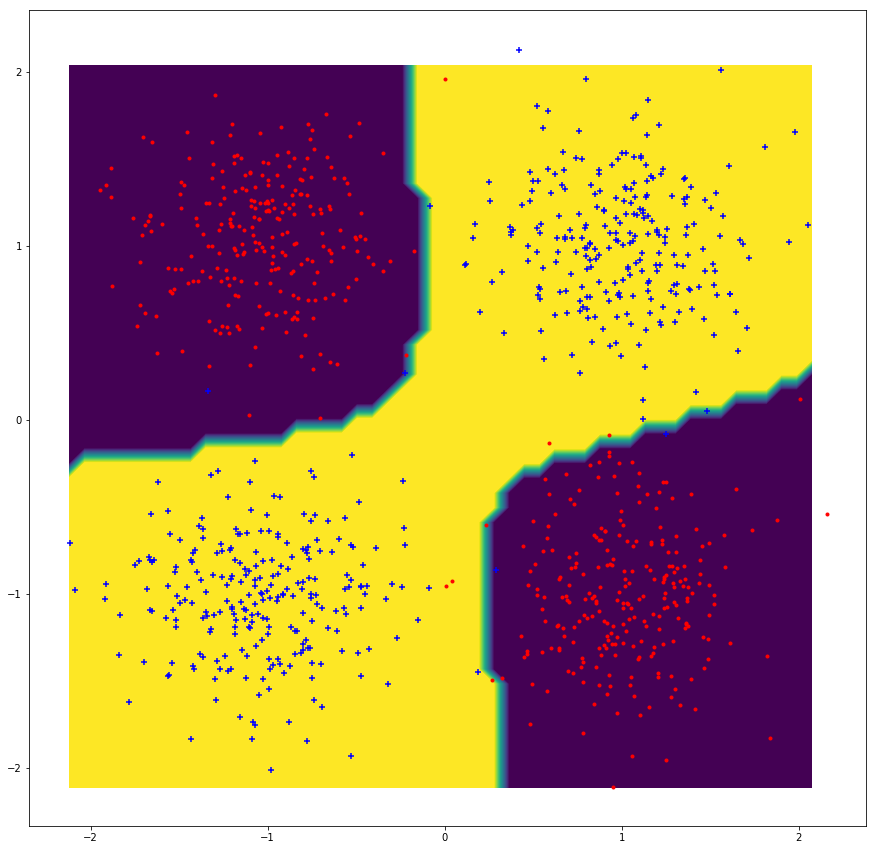

In [25]:
# ### Generation de donnees

xtrain, ytrain = gen_arti(data_type=1, epsilon=0.2)
xtest, ytest = gen_arti(data_type=1, epsilon=0.2)

n_dim = 20
gen="autre"

n_ex, n_dim_in  = xtrain.shape

if gen == "rand":
    o = np.random.rand(n_dim, n_dim_in)
    projec = lambda x : kernel(x, type="rand", n_dim=20)
else :
    index = np.random.randint(n_ex, size=n_dim)
    o = xtrain[index, :]
    projec = lambda x : kernel(x, o, n_dim=n_dim, sigma=3)
    

### Apprentissage
model = Perceptron(eps=1e-2, projection=projec)
model.fit(xtrain, ytrain)
print("score en train : ", model.score(xtrain, ytrain))
print("score en test : ", model.score(xtest, ytest))

#### Tracer de frontiere
plt.figure(num=None, figsize=(15, 15))
plot_frontiere(xtrain, model.predict, 50)
plot_data(xtrain, ytrain)
plt.show()